In [1]:
import infomap
import networkx as nx
import pydot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

In [2]:
print("networkx " + nx.__version__)
print("pandas " +pd.__version__)
!python3 --version

networkx 2.4
pandas 0.25.3
Python 3.7.5


When generating the Influence Matrix, we run simulations disconnecting one line at a time. But sometimes disconnecting a line breaks the grid into two components and then balancing mecanims on the grid are activated and run in the simulation. We might want to represent this phenomena or not. 

More generally, the power grid is less meshed towards its end, with bi-connected components: only one node connects two comonents of the grid. Then we might consider that those residual bi-components from the core of the grid can already form a community by themselves that we don't have to find

<img src="Pictures/ClusterIEEE118.png" width=700 height=40>

On this power grid segmentation, the black lines belong to end chain co

In [ ]:
doRemoveEndChains=True #True if you don't wan

# Load the input data

In [ ]:
import zipfile
with zipfile.ZipFile('data/InfluenceMatrix.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [4]:
input_data = pd.read_csv('data/InfluenceMatrix/AS_table.csv', index_col=0)#pd.read_csv('InfluenceMatrix/AS_table.csv', index_col=0)

In [5]:
input_data.head()

,line_15,line_16,line_189,line_190,line_297,line_298,line_299,line_300,line_301,line_302,...,line_8099,line_8100,line_8101,line_8102,line_8103,line_8104,line_8105,line_8106,line_8107,line_8108
line_15,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
line_16,98.811409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
line_189,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
line_190,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
line_297,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


# Preprocess the data
Not True anymore: The data is the absolute redispatching value in MW, not the redispatching ratio, as we check in the following cell

In [5]:
input_data.values

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [98.811409  ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.63046002,  0.62875301,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## round it to proper accuracy

In [7]:
#round it to 0.1MW accuracy
input_data=np.round(input_data,decimals=1)
input_data.head()

,line_15,line_16,line_189,line_190,line_297,line_298,line_299,line_300,line_301,line_302,...,line_8099,line_8100,line_8101,line_8102,line_8103,line_8104,line_8105,line_8106,line_8107,line_8108
line_15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
line_16,98.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
line_189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
line_190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
line_297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


## Remove non-sensitive assets

In [8]:
#remove it to 0 column and rows
rowSum=input_data.sum(axis=1)#summing for one row on every column
colSum=input_data.sum(axis=0)
indicesToRemove=[i for i in range(len(rowSum)) if rowSum[i]==0.0 and colSum[i]==0.0]
print("these indices have no sensibilities: remove them")
len(indicesToRemove)

these indices have no sensibilities: remove them


0

In [9]:
#removing indices
input_data=input_data.drop(input_data.columns [indicesToRemove], axis=0)
input_data=input_data.drop(input_data.columns [indicesToRemove], axis=1)
input_data.reset_index(drop=True)
input_data.head()

,line_15,line_16,line_189,line_190,line_297,line_298,line_299,line_300,line_301,line_302,...,line_8099,line_8100,line_8101,line_8102,line_8103,line_8104,line_8105,line_8106,line_8107,line_8108
line_15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
line_16,98.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
line_189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
line_190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
line_297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


## Remove end chains

Let s relove end chains, that is part of the grid that is only connected through one node to the biggest part of the grid.
We will use biconnected component function

In [10]:
nonZerosPerRow=input_data.astype(bool).sum(axis=1)

In [11]:
#import plotly.graph_objects as go
#fig = go.Figure(data=go.Scatter(x=list(range(0, len(nonZerosPerRow))),y=nonZerosPerRow))
#fig.show()

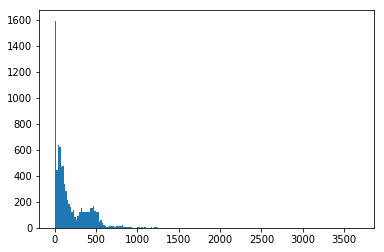

In [12]:
plt.hist(nonZerosPerRow,bins=200)
plt.show()

In [13]:
grid_topology= pd.read_csv('data/topo.csv', index_col=0)#pd.read_csv('InfluenceMatrix/AS_table.csv', index_col=0)

In [14]:
grid_topology

,nameNodeOr,nameNodeEx,Quadripole
0,node_468,node_4202,line_15
1,node_468,node_4856,line_16
2,node_5491,node_1665,line_189
3,node_5491,node_3250,line_190
4,node_4997,node_3766,line_297
...,...,...,...
8050,node_1726,node_4681,line_8104
8051,node_2711,node_2807,line_8105
8052,node_2199,node_1552,line_8106
8053,node_2732,node_3058,line_8107


In [15]:
G = nx.from_pandas_edgelist(grid_topology, source='nameNodeOr', target='nameNodeEx',edge_attr=True)
#nx.from_pandas_edgelist(df, 0, 'b', ['weight', 'cost'])

We should remove nodes

In [16]:
bicomponents = list(nx.biconnected_components(G))
bicomponents

[{'node_5288', 'node_5328'},
 {'node_4981', 'node_5288'},
 {'node_4146', 'node_831'},
 {'node_4146', 'node_4981'},
 {'node_1743', 'node_997'},
 {'node_1743', 'node_4981'},
 {'node_385', 'node_4888'},
 {'node_385', 'node_4981'},
 {'node_3111', 'node_5345'},
 {'node_3111', 'node_3155'},
 {'node_3155', 'node_3529'},
 {'node_3454', 'node_3529'},
 {'node_2271', 'node_986'},
 {'node_4519', 'node_986'},
 {'node_3913', 'node_3917'},
 {'node_3578', 'node_754'},
 {'node_4384', 'node_5143'},
 {'node_3848', 'node_5143'},
 {'node_2704', 'node_4648'},
 {'node_3312', 'node_3984'},
 {'node_3824', 'node_5030'},
 {'node_3824', 'node_4046'},
 {'node_194', 'node_2254'},
 {'node_4129', 'node_648'},
 {'node_5206', 'node_613'},
 {'node_1274', 'node_137'},
 {'node_1064', 'node_964'},
 {'node_298', 'node_4066'},
 {'node_3574', 'node_3999'},
 {'node_2844', 'node_3574'},
 {'node_228', 'node_4614'},
 {'node_1710', 'node_3342'},
 {'node_2313', 'node_568'},
 {'node_1342', 'node_2313'},
 {'node_2279', 'node_4960'},


In [17]:
bicomponentsSorted=[c for c in sorted(bicomponents, key=len, reverse=True)]

In [18]:
BigComponent=bicomponentsSorted[0]
BigComponent

{'node_5248',
 'node_1383',
 'node_3160',
 'node_1339',
 'node_60',
 'node_2644',
 'node_4617',
 'node_5323',
 'node_3831',
 'node_1593',
 'node_3735',
 'node_2168',
 'node_3443',
 'node_4647',
 'node_4649',
 'node_5181',
 'node_4143',
 'node_4737',
 'node_5103',
 'node_2980',
 'node_399',
 'node_1920',
 'node_631',
 'node_5228',
 'node_3726',
 'node_4897',
 'node_192',
 'node_1575',
 'node_3528',
 'node_3377',
 'node_2964',
 'node_3183',
 'node_275',
 'node_397',
 'node_1994',
 'node_5339',
 'node_5433',
 'node_2115',
 'node_2247',
 'node_753',
 'node_5523',
 'node_2370',
 'node_5172',
 'node_5008',
 'node_163',
 'node_607',
 'node_2052',
 'node_2036',
 'node_1527',
 'node_2952',
 'node_3026',
 'node_2294',
 'node_5572',
 'node_2736',
 'node_122',
 'node_681',
 'node_4956',
 'node_1769',
 'node_4542',
 'node_5131',
 'node_2845',
 'node_5390',
 'node_4329',
 'node_2228',
 'node_4581',
 'node_2332',
 'node_1772',
 'node_1443',
 'node_3661',
 'node_1251',
 'node_273',
 'node_3166',
 'nod

In [19]:
GraphNodes=list(G.nodes())
NodeToRemove=[node for node in GraphNodes if node not in BigComponent]

In [20]:
NodeToRemove

['node_2048',
 'node_4825',
 'node_701',
 'node_3367',
 'node_2334',
 'node_2171',
 'node_2841',
 'node_3386',
 'node_3717',
 'node_4169',
 'node_3538',
 'node_5622',
 'node_2490',
 'node_1898',
 'node_1170',
 'node_1231',
 'node_2648',
 'node_293',
 'node_2605',
 'node_281',
 'node_1487',
 'node_1590',
 'node_4071',
 'node_1908',
 'node_4645',
 'node_1106',
 'node_3405',
 'node_1098',
 'node_4381',
 'node_1836',
 'node_767',
 'node_1859',
 'node_2904',
 'node_86',
 'node_1494',
 'node_1996',
 'node_4827',
 'node_4850',
 'node_5235',
 'node_1031',
 'node_5439',
 'node_4903',
 'node_4422',
 'node_3816',
 'node_5204',
 'node_5177',
 'node_3744',
 'node_2878',
 'node_5313',
 'node_3799',
 'node_1882',
 'node_4325',
 'node_726',
 'node_4569',
 'node_1776',
 'node_1976',
 'node_5155',
 'node_4864',
 'node_269',
 'node_4095',
 'node_17',
 'node_4794',
 'node_5492',
 'node_3611',
 'node_4396',
 'node_448',
 'node_1723',
 'node_4664',
 'node_3770',
 'node_4769',
 'node_3475',
 'node_2517',
 'n

In [21]:
print(len(G))
print(nx.number_of_edges(G))

5627
7163


In [22]:
for node in NodeToRemove:
    G.remove_node(node)

In [23]:
print(len(G))
print(nx.number_of_edges(G))

3189
4542


In [24]:
linesToKeep=list(nx.get_edge_attributes(G,'Quadripole').values())

In [25]:
len(linesToKeep)

4542

In [26]:
linesToNotConsider=[line for line in list(input_data.columns) if line not in linesToKeep]
linesToNotConsider

['line_297',
 'line_317',
 'line_318',
 'line_398',
 'line_508',
 'line_510',
 'line_548',
 'line_875',
 'line_1212',
 'line_1385',
 'line_1641',
 'line_1688',
 'line_2040',
 'line_1849',
 'line_2206',
 'line_2207',
 'line_3015',
 'line_3049',
 'line_3050',
 'line_3283',
 'line_3340',
 'line_3343',
 'line_3344',
 'line_3348',
 'line_3541',
 'line_3575',
 'line_3577',
 'line_3932',
 'line_4182',
 'line_4321',
 'line_4356',
 'line_4437',
 'line_4459',
 'line_4461',
 'line_4462',
 'line_4506',
 'line_4570',
 'line_4637',
 'line_4653',
 'line_4792',
 'line_4796',
 'line_5685',
 'line_6234',
 'line_6415',
 'line_6439',
 'line_6544',
 'line_6549',
 'line_7893',
 'line_7929',
 'line_7930',
 'line_7931',
 'line_1',
 'line_3',
 'line_4',
 'line_19',
 'line_23',
 'line_24',
 'line_38',
 'line_112',
 'line_113',
 'line_114',
 'line_115',
 'line_116',
 'line_175',
 'line_176',
 'line_179',
 'line_273',
 'line_529',
 'line_530',
 'line_715',
 'line_5',
 'line_11',
 'line_12',
 'line_13',
 'line_14'

In [27]:
if doRemoveEndChains:

    newIputData=input_data.drop(linesToNotConsider,axis=0)
    newIputData=newIputData.drop(linesToNotConsider,axis=1)
else:
    newIputData=input_data

In [28]:
nonZerosPerRow=newIputData.astype(bool).sum(axis=1)

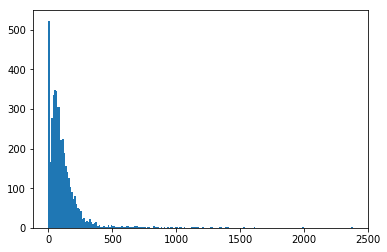

In [29]:
plt.hist(nonZerosPerRow,bins=200)
plt.show()

We can see that we removed the "second mode" in the data from the previous histogram (if doRemoveEndChains is True)

## Remove non connected components

In [30]:
newIputData.values.shape

(4542, 4542)

In [31]:
newIputData

,line_15,line_16,line_189,line_190,line_298,line_299,line_300,line_301,line_302,line_399,...,line_8096,line_8097,line_8098,line_8099,line_8100,line_8101,line_8102,line_8103,line_8105,line_8106
line_15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_16,98.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
line_8101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_8102,0.0,0.0,0.0,0.0,0.3,0.9,0.2,0.2,0.0,0.2,...,11.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_8103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_8105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9


In [32]:
list(newIputData)#input_data.columns.values

['line_15',
 'line_16',
 'line_189',
 'line_190',
 'line_298',
 'line_299',
 'line_300',
 'line_301',
 'line_302',
 'line_399',
 'line_401',
 'line_506',
 'line_507',
 'line_509',
 'line_511',
 'line_512',
 'line_513',
 'line_514',
 'line_515',
 'line_547',
 'line_549',
 'line_553',
 'line_554',
 'line_656',
 'line_657',
 'line_672',
 'line_673',
 'line_731',
 'line_732',
 'line_809',
 'line_810',
 'line_748',
 'line_749',
 'line_750',
 'line_751',
 'line_752',
 'line_823',
 'line_824',
 'line_825',
 'line_826',
 'line_827',
 'line_828',
 'line_829',
 'line_830',
 'line_831',
 'line_832',
 'line_872',
 'line_873',
 'line_874',
 'line_877',
 'line_882',
 'line_883',
 'line_901',
 'line_905',
 'line_1016',
 'line_1017',
 'line_1018',
 'line_1019',
 'line_1050',
 'line_1051',
 'line_1115',
 'line_1116',
 'line_1117',
 'line_1118',
 'line_1119',
 'line_1176',
 'line_1177',
 'line_1178',
 'line_1179',
 'line_1213',
 'line_1214',
 'line_1215',
 'line_1216',
 'line_1218',
 'line_1219',
 'line

Create networkx Graph to run connected components algo

In [33]:
G = nx.DiGraph(newIputData.values)

quadNames=list(newIputData)
for node in G.nodes():
    G.add_node(node, name=quadNames[node])
#nodeAttribute
#nx.set_node_attributes(G, list(input_data), 'name')

In [34]:
#nx.write_pajek(G, "InfluenceMatrix.net")

In [35]:
#keep only biggest connected components
print("number of nodes before:"+str(G.number_of_nodes()))
largest_cc = max(nx.weakly_connected_components(G), key=len)
G=G.subgraph(largest_cc)
print("number of nodes after:"+str(G.number_of_nodes()))

number of nodes before:4542
number of nodes after:4539


Remove lines not in main component

In [36]:
linesToKeep=list(nx.get_node_attributes(G,'name').values())
len(linesToKeep)

4539

In [37]:
quadNames=list(newIputData)
LinesToRemove=[s for s in quadNames if s not in linesToKeep]
LinesToRemove

['line_3280', 'line_3871', 'line_4458']

In [38]:
newIputData=newIputData.drop(LinesToRemove,axis=0)
newIputData=newIputData.drop(LinesToRemove,axis=1)

In [39]:
newIputData

,line_15,line_16,line_189,line_190,line_298,line_299,line_300,line_301,line_302,line_399,...,line_8096,line_8097,line_8098,line_8099,line_8100,line_8101,line_8102,line_8103,line_8105,line_8106
line_15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_16,98.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
line_8101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_8102,0.0,0.0,0.0,0.0,0.3,0.9,0.2,0.2,0.0,0.2,...,11.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_8103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_8105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9


In [40]:
newIputData.shape

(4539, 4539)

## Save Data

In [41]:
newIputData.to_csv('data/InfluenceMatrix/AS_table_preprocessed_withTopo.csv', index=True)